In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
import seaborn as sns

## use display for html output
from IPython.display import display, HTML

# auto-reload modules
%load_ext autoreload
%autoreload 2

# set dark theme
plt.style.use('dark_background')

In [2]:
df = pd.read_csv('./data/WID_Data_pretax_India_national_income.csv', sep=';')
df_average_income = pd.read_csv('./data/WID_Data_average_income.csv', sep=';')
df = df.dropna()
df.head()

,percentile,year,percentage
0,p90p100,1820,0.4800
30,p90p100,1850,0.5000
60,p90p100,1880,0.5460
80,p90p100,1900,0.5376
90,p90p100,1910,0.4480


In [3]:
# sort the data according to the year
df = df.sort_values(by=['year'])
df.head()

,percentile,year,percentage
0,p90p100,1820,0.4800
404,p99p100,1820,0.1600
202,p0p50,1820,0.1756
30,p90p100,1850,0.5000
434,p99p100,1850,0.1800


In [4]:
# filter all the years that are less than 1980 
df = df[df['year'] >= 1980]
df.head()

,percentile,year,percentage
564,p99p100,1980,0.0754
160,p90p100,1980,0.3236
362,p0p50,1980,0.2121
363,p0p50,1981,0.2139
565,p99p100,1981,0.0688


In [5]:
# count the number of years that aren't repeated 3 times and show the years
years_count = df['year'].value_counts()
years_count[years_count != 3]

Series([], Name: year, dtype: int64)

In [6]:
# iterate every three rows and calulate the p50p90 for all the years
p50p90 = {
    'year': [],
    'percentile': [],
    'percentage': []
}
p90p99 = {
    'year': [],
    'percentile': [],
    'percentage': []
}
for i in range(0, len(df), 3):
    df_temp = df.iloc[i:i+3]
    p99p100 = df_temp[df_temp['percentile'] == 'p99p100']   
    p90p100 = df_temp[df_temp['percentile'] == 'p90p100']
    p0p50 = df_temp[df_temp['percentile'] == 'p0p50']

    p50p90['year'].append(p90p100['year'].values[0])
    p90p99['year'].append(p90p100['year'].values[0])
    p50p90['percentile'].append('p50p90')
    p90p99['percentile'].append('p90p99')

    p50p90['percentage'].append( 1 - (p90p100['percentage'].values[0] + p0p50['percentage'].values[0]) )
    p90p99['percentage'].append( p90p100['percentage'].values[0] -p99p100['percentage'].values[0] ) 

p50p90 = pd.DataFrame(p50p90)
p90p99 = pd.DataFrame(p90p99)
p90p99.head()

,year,percentile,percentage
0,1980,p90p99,0.2482
1,1981,p90p99,0.2467
2,1982,p90p99,0.2459
3,1983,p90p99,0.2558
4,1984,p90p99,0.2512


In [7]:
# add the p50p90 and p90p99 to the dataframe
df = df.append(p50p90)
df = df.append(p90p99)
df = df.sort_values(by=['year'])
df.head()

,percentile,year,percentage
564,p99p100,1980,0.0754
160,p90p100,1980,0.3236
362,p0p50,1980,0.2121
0,p90p99,1980,0.2482
0,p50p90,1980,0.4643


In [8]:
# remove the p90p100 as it's not needed anymore
df = df[df['percentile'] != 'p90p100']

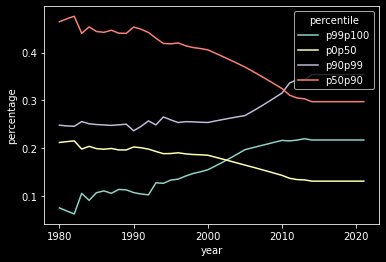

In [9]:
# plot the data x-axis year; y-axis: percentage; hue: percentile
sns.lineplot(x='year', y='percentage', hue='percentile', data=df)

From this graph we can observe how each percentile in India is performing and how it's percentage of contribution to Indian economy is. 
Here we can observe that the top 10% of the population is contributing to 55% of the economy. And the top 1% of the population is contributing to above 20% of the economy.And has the maximum amount of wealth.

In [11]:
year = 2019 
# take the year 2019 
df_2019 = df[df['year'] == year]

In [ ]:
from calculate_tax import tax_india_2019

def percentile_str_to_float(x: str) -> float:
    """ Converts the labels into float p90p100 -> ( 90 + 100 ) / 2 = 95 """
    return float(sum( [int(i) for i in x.split('p') if i != ""])/2 )

def get_income(percentile_str: str, avg_income: float) -> float:
    """ Returns the income for a given percentile """
    income = percentile_str_to_float(percentile_str) * avg_income
    return income

average_income_2019 = df_average_income[df_average_income['year'] == year]['income'].values[0]
df_2019['income'] = df_2019['percentile'].apply(lambda x: get_income(x, average_income_2019))
df_2019['tax'] = df_2019['income'].apply(lambda x: tax_india_2019(x))
df_2019['taxed_income'] = df_2019['income'] - df_2019['tax']

In [13]:
# remove duplicate perceniles 
df_2019 = df_2019.drop_duplicates(subset=['percentile'])

In [14]:
# caluculate the percentage of the taxed income
df_2019['taxed_income_percentage'] = df_2019['taxed_income'] / df_2019['taxed_income'].sum()

Text(0.5, 1.0, 'Income distribution in India 2019 after taxing')

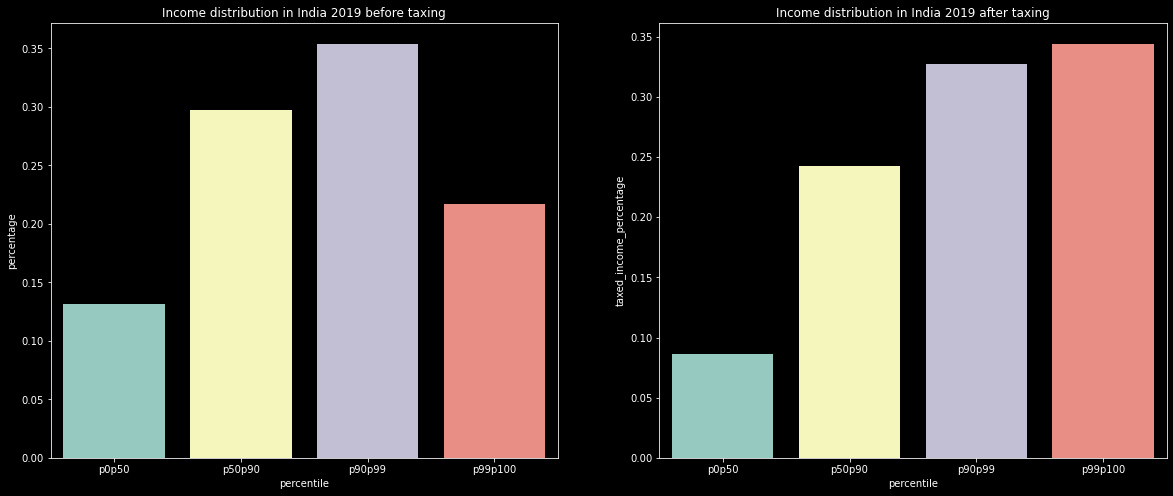

In [15]:
# sort by percentile 
df_2019 = df_2019.sort_values(by=['percentile'])

# show percentage and taxed income percentage side by side 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))


sns.barplot(x='percentile', y='percentage', data=df_2019, ax=ax1)
ax1.set_title('Income distribution in India 2019 before taxing')

sns.barplot(x='percentile', y='taxed_income_percentage', data=df_2019, ax=ax2)
ax2.set_title('Income distribution in India 2019 after taxing')

In [16]:
# take percentile year and percenetage out 
df_2019_ = df_2019[['percentile', 'percentage']]
df_2019_.head()

,percentile,percentage
401,p0p50,0.1313
39,p50p90,0.2974
39,p90p99,0.3540
603,p99p100,0.2173


Text(0.5, 1.0, 'Income distribution in India 2019 after taxing')

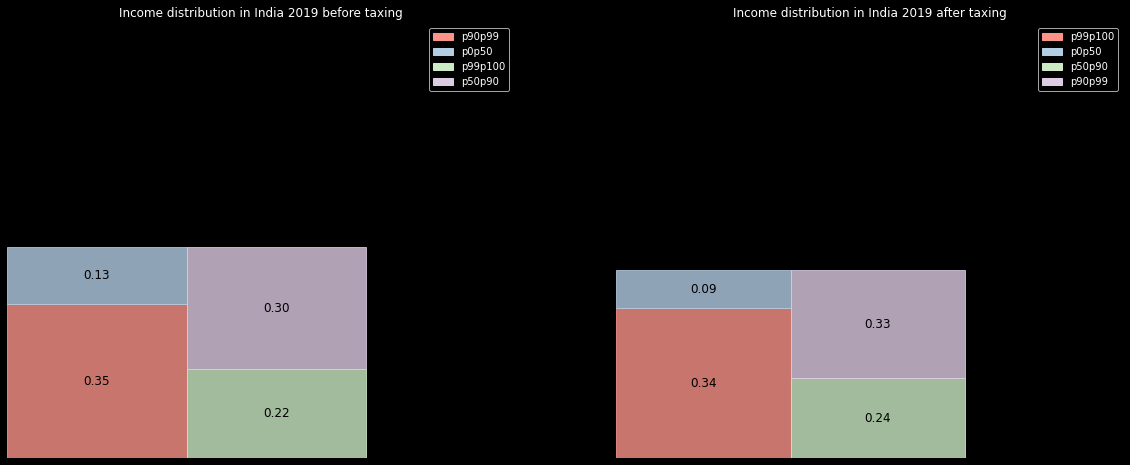

In [154]:
from .square_area_proportion_plot import square_area_proportion_plot


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
square_area_proportion_plot(df_2019_, ax=ax1)
ax1.set_title('Income distribution in India 2019 before taxing')
_df = df_2019[['percentile', 'taxed_income_percentage']]
# rename taxed_income_percentage -> percentage
_df = _df.rename(columns={'taxed_income_percentage': 'percentage'})
square_area_proportion_plot(_df, ax=ax2)
ax2.set_title('Income distribution in India 2019 after taxing')